In [1]:
from typing import List, Dict
import gensim
import numpy as np

In [2]:
def parse_fasta_dataset(file_path: str = "../data/LTP_09_2021_compressed.fasta.txt", max_seqs:int = False) -> List[Dict[str, str]]:
    dataset = []
    current_idx = 0
    current_meta = {}
    with open(file_path, "r") as f:
        for line in f.readlines():
            if line[0] == ">":
                if current_meta != {}:
                    current_meta["sequence"] = current_meta["sequence"].strip()
                    dataset.append(current_meta)
                line_list = line.replace("\n", "").replace(">", "").split("\t")
                current_meta  = {key: line_list[idx] for idx, key in enumerate(["id", "name", "tags"])}
                current_meta["tags"] = current_meta["tags"].split(";")
                current_meta["sequence"] = ""
                current_idx += 1
                if current_idx > max_seqs and max_seqs>=1:
                    break
            else:
                current_meta["sequence"] += line.replace("\n", " ")
    return dataset

dataset = parse_fasta_dataset(max_seqs=-1)
print(len(dataset))

17959


In [292]:
staph_strains = [x for x in dataset if x['name'][0:5] == "Staph"]
staph_strains

[{'id': 'AB009938',
  'name': 'Staphylococcus delphini',
  'tags': ['Bacteria',
   'Firmicutes',
   'Bacilli',
   'Caryophanales',
   'Staphylococcaceae',
   'Staphylococcus'],
  'sequence': 'AGAGUUUGAU CCUGGCUCAG UAUGAACGCU GGCGGCGUGC CUAAUACAUG CAAGUCGAGC GAACAGAUAA GGAGCUUGCU CCUUUGACGU UAGCGGCGGA CGGGUGAGUA ACACGUGGGU AACCUACCUA UAAGACUGGA AUAACUCCGG GAAACCGGGG CUAAUGCCGG AUAACAUGUU GAACCGCAUG GUUCUACAGU GAAAGACGGU CUUGCUGUCA CUUAUAGAUG GACCCGCGCC GUAUUAGCUA GUUGGUGGGG UAACGGCCUA CCAAGGCGAC GAUACGUAGC CGACCUGAGA GGGUGAUCGG CCACACUGGA ACUGAGACAC GGUCCAGACU CCUACGGGAG GCAGCAGUAG GGAAUCUUCC GCAAUGGGCG AAAGCCUGAC GGAGCAACGC CGCGUGAGUG AUGAAGGUCU UCGGAUCGUA AAGCUCUGUU GUUAGGGAAG AACAAAUGUG UAAGUAACUG UGCACAUCUU GACGGUACCU AACCAGAAAG CCACGGCUAA CUACGUGCCA GCAGCCGCGG UAAUACGUAG GUGGCAAGCG UUAUCCGGAA UUAUUGGGCG UAAAGCGCGC GUAGGCGGUU UUUUAAGUCU GAUGUGAAAG CCCACGGCUC AACCGUGGAG GGUCAUUGGA AACUGGAAAA CUUGAGUGCA GAAGAGGAAA GUGGAAUUCC AUGUGUAGCG GUGAAAUGCG CAGAGAUAUG GAGGAACACC AGUGGCGAAG GCGGC

In [293]:
# BASES = {"A": "000", "C": "001", "G": "010", "T": "011", "_": "100"}

# def is_valid_padding(key_string: str) -> bool:
#     if "_" not in key_string[:-2] and key_string[-1] == "_":
#         return True
#     elif "_" not in key_string[:-3] and key_string[-2:] == "__":
#         return True
#     elif "_" not in key_string[:-4] and key_string[-3:] == "___":
#         return True
#     return False

# BASE_MAP = {}

# for key1, val1 in BASES.items():
#     for key2, val2 in BASES.items():
#         for key3, val3 in BASES.items():
#             for key4, val4 in BASES.items():
#                 key_string = key1 + key2 + key3 + key4
#                 if "_" not in key_string:
#                     print(
#                         key1 + key2 + key3 + key4,
#                         "->",
#                         val1 + val2 + val3 + val4,
#                         "(",
#                         int(val1 + val2 + val3 + val4, base=2),
#                         ")",
#                     )
#                     BASE_MAP[key1 + key2 + key3 + key4] = int(
#                         val1 + val2 + val3 + val4, base=2
#                     )
#                 else:
#                     if is_valid_padding(key_string):
#                         print(
#                             key1 + key2 + key3 + key4,
#                             "->",
#                             val1 + val2 + val3 + val4,
#                             "(",
#                             int(val1 + val2 + val3 + val4, base=2),
#                             ")",
#                         )
#                         BASE_MAP[key1 + key2 + key3 + key4] = int(
#                             val1 + val2 + val3 + val4, base=2
#                         )

# for key, val in SPECIAL.items():
#     BASE_MAP[key] = val


# print(BASE_MAP)
# print(len(BASE_MAP))

In [294]:
def chunk_seq(seq: str, chunk_len: int = 4):
    ret_list = []
    chunk = ""
    for idx, char in enumerate(seq):
        chunk += char
        if len(chunk) % chunk_len ==0:
            ret_list.append(chunk)
            chunk=""
    if len(chunk) > 0:
        ret_list.append("{}{}".format(chunk, "_"*(4-len(chunk))))
    return ret_list

# clean_seq = dataset[0]["sequence"].replace(" ", "")
# chunks = chunk_seq(clean_seq)
# print(chunks)

In [299]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(" ".join(chunk_seq(x["sequence"].replace(" ", ""), 1)), [x["name"]]) for x in dataset]
# documents = [TaggedDocument(" ".join(chunk_seq(x["sequence"].replace(" ", ""), 1)), [x["name"]]) for x in lacto_strains]

In [300]:
model = gensim.models.Doc2Vec(
    epochs=50,
    documents=documents, 
    workers=8, 
    vector_size=64,
    negative=10,
    dm=1,
    hs=0,
    window=32,
    min_alpha=0.0001,
)

In [301]:
# [(x, y) for x, y in model.docvecs.doctags.items()]

In [302]:
# model.docvecs.doctags.keys()

In [303]:
seq_ids = {key: model.docvecs[key] for key in model.docvecs.doctags.keys()}

In [313]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot as plt
import seaborn as sns

def plot_nodes(seq_ids: Dict[str, np.array], figsize=(50,50)):
    X = np.array([x for x in seq_ids.values()])
    
    # reduce dimensions to 2
    pca = TSNE(n_components=2, n_jobs=-1)
    result = pca.fit_transform(X)

    cluster = AffinityPropagation(random_state=42)
    cluster.fit(result)
    
    plt.figure(figsize=figsize)
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1], c=cluster.labels_, cmap=sns.color_palette("Spectral", as_cmap=True))
    for i, word in enumerate([x for x in seq_ids.keys()]):
        c = 'grey'
        if i in cluster.cluster_centers_indices_:
            c = 'black'
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), c=c)

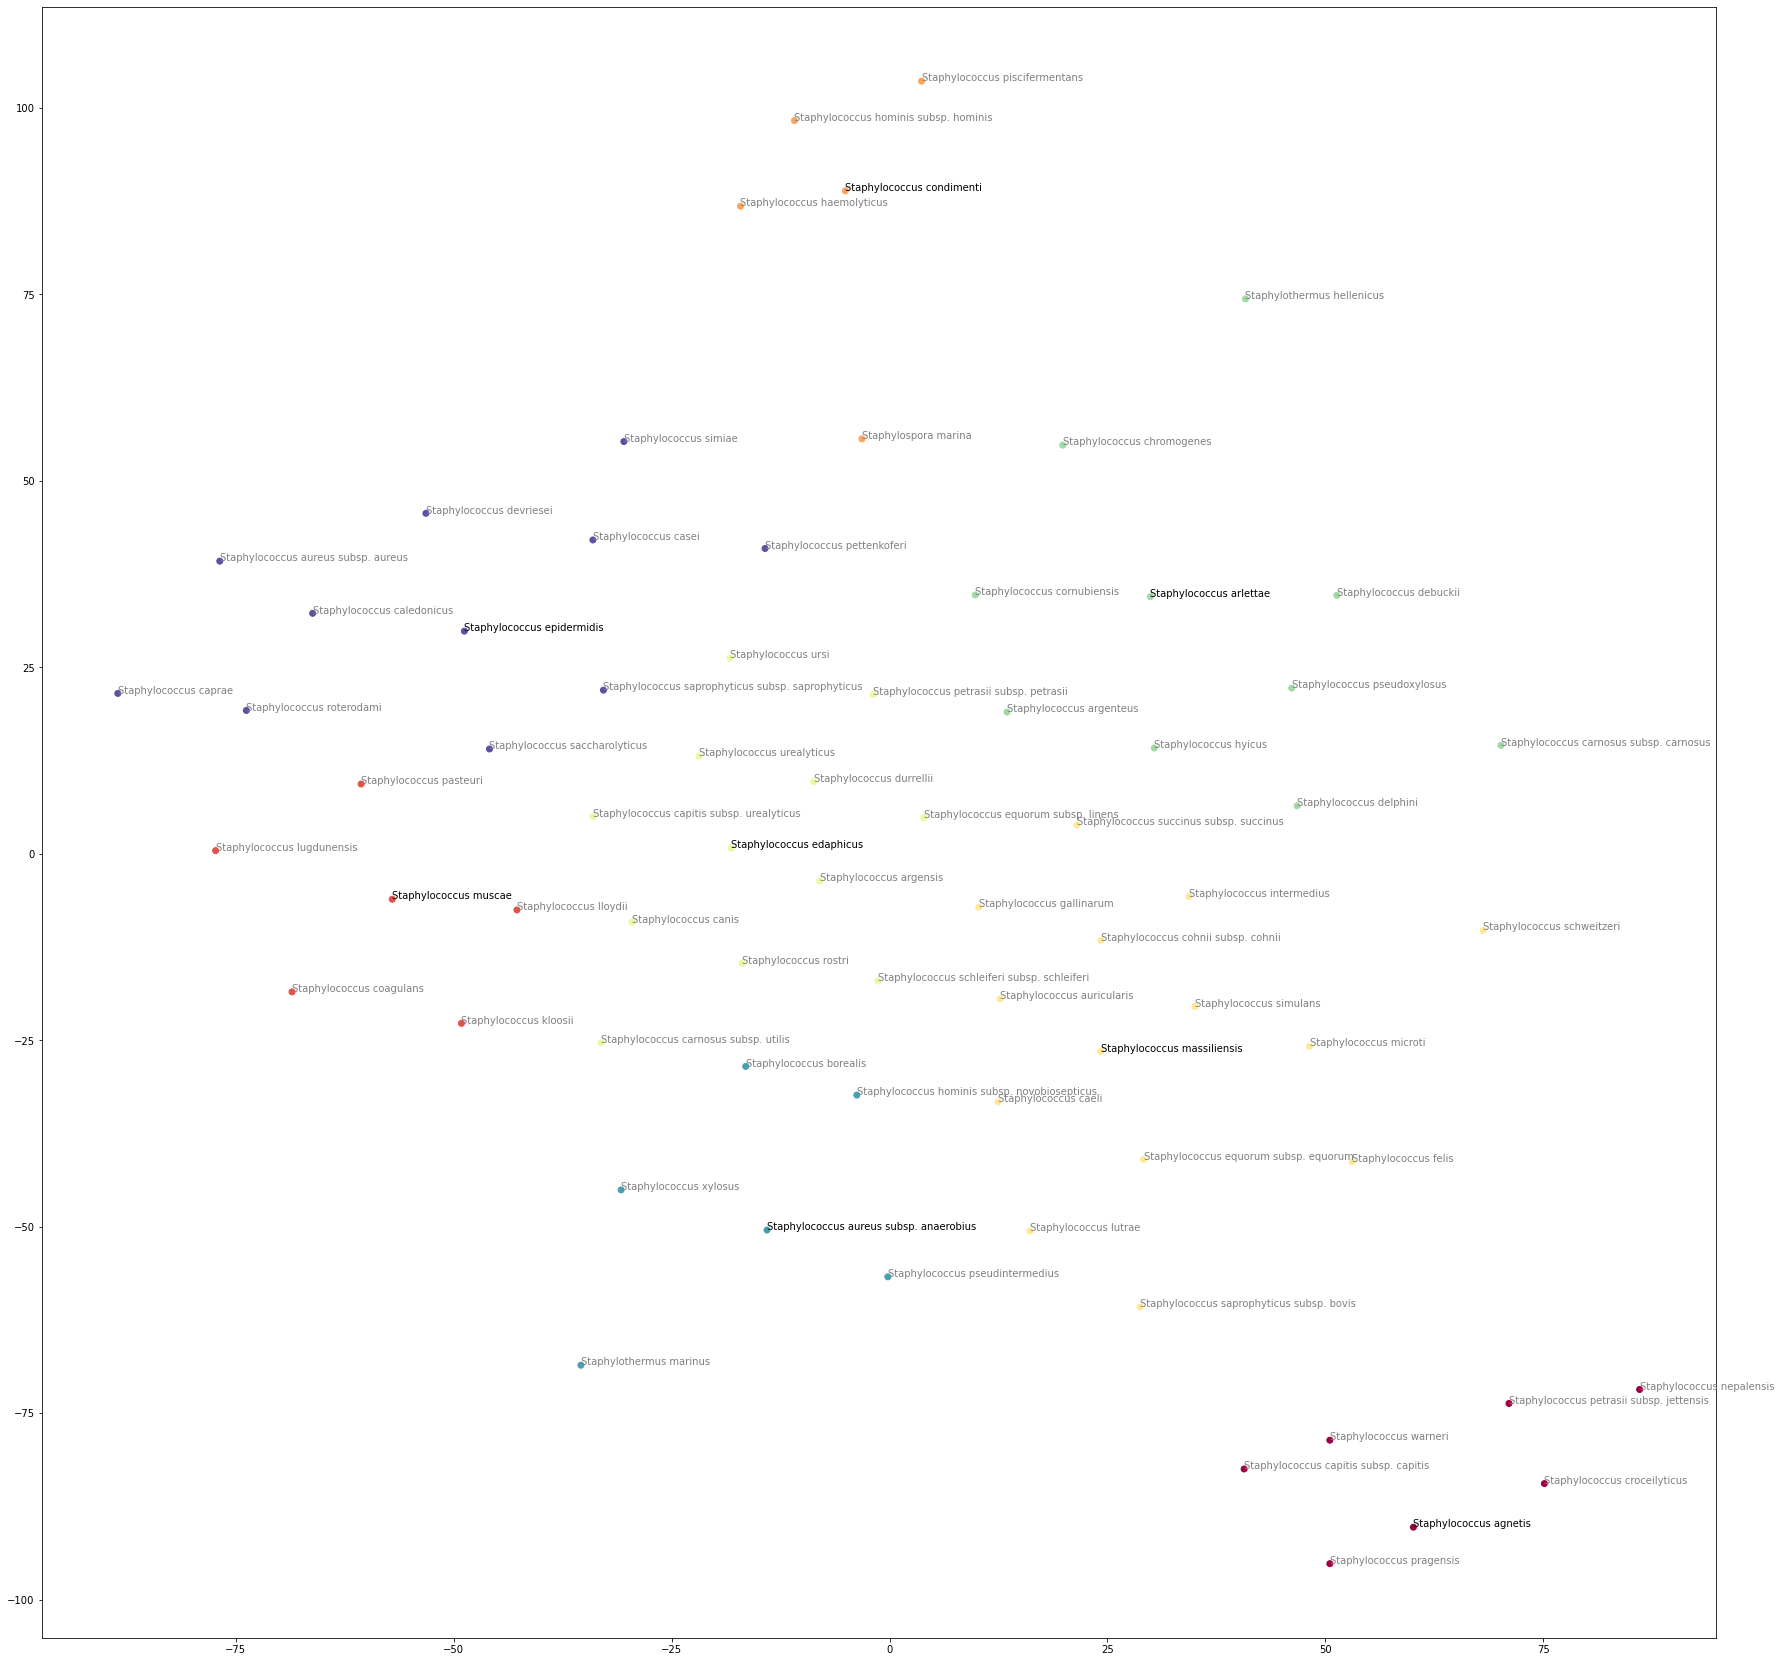

In [314]:
# from itertools import islice
# from random import choices

# def take(n, iterable):
#     "Return first n items of the iterable as a list"
#     return dict(choices(iterable, k=n))

# random_sample = choices([{key: val} for key, val in seq_ids.items()], k=500)
random_sample = [{x['name']: seq_ids[x['name']]} for x in staph_strains]

random_sample_dict = {}
for item in random_sample:
    for key, val in item.items():
        random_sample_dict[key] = val
        
plot_nodes(random_sample_dict, figsize=(30, 30))